# Explore here

In [42]:
#Los IMPORTS
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import joblib
import warnings
warnings.filterwarnings('ignore')



In [43]:
#Cargamos CSV
url = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
pd.read_csv(url).to_csv("../data/raw/sales.csv", index=False)

In [44]:
df = pd.read_csv("../data/raw/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [45]:
#Convertimos a fecha (date)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()
ts = df['sales']

print(f"Total de observaciones: {len(ts)} días")
print(f"Desde: {ts.index[0].date()} → Hasta: {ts.index[-1].date()}")

Total de observaciones: 366 días
Desde: 2022-09-03 → Hasta: 2023-09-03


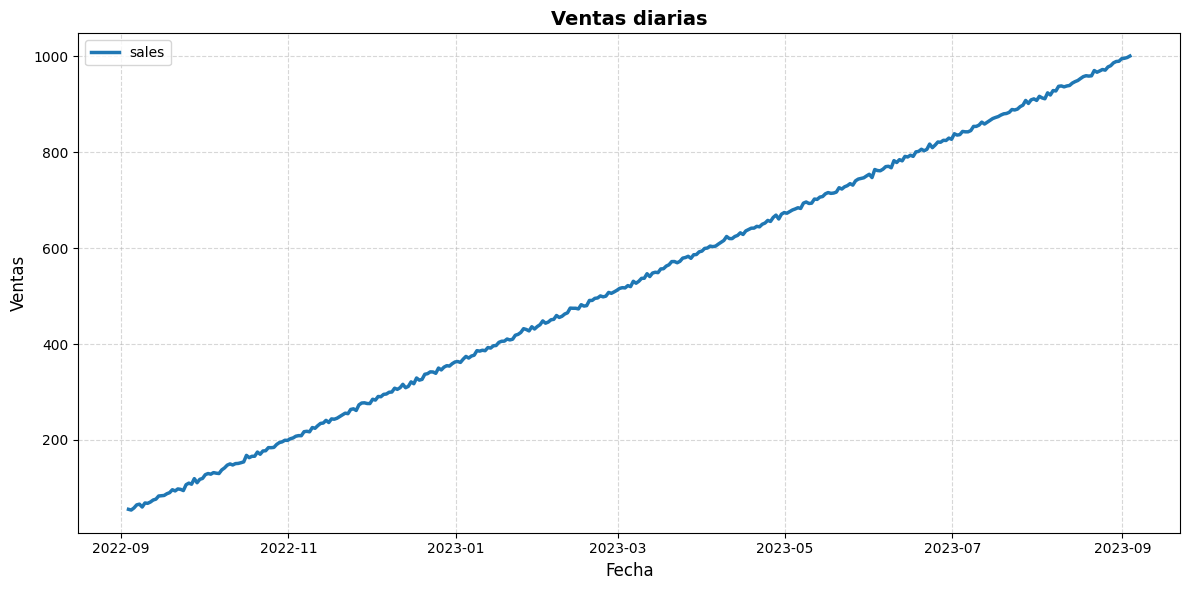

In [46]:
#Graficamos las ventas realizadas por día

fig, axis = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df, color="green", linewidth=2.5)

plt.title("Ventas diarias", fontsize=14, fontweight="bold")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Ventas", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


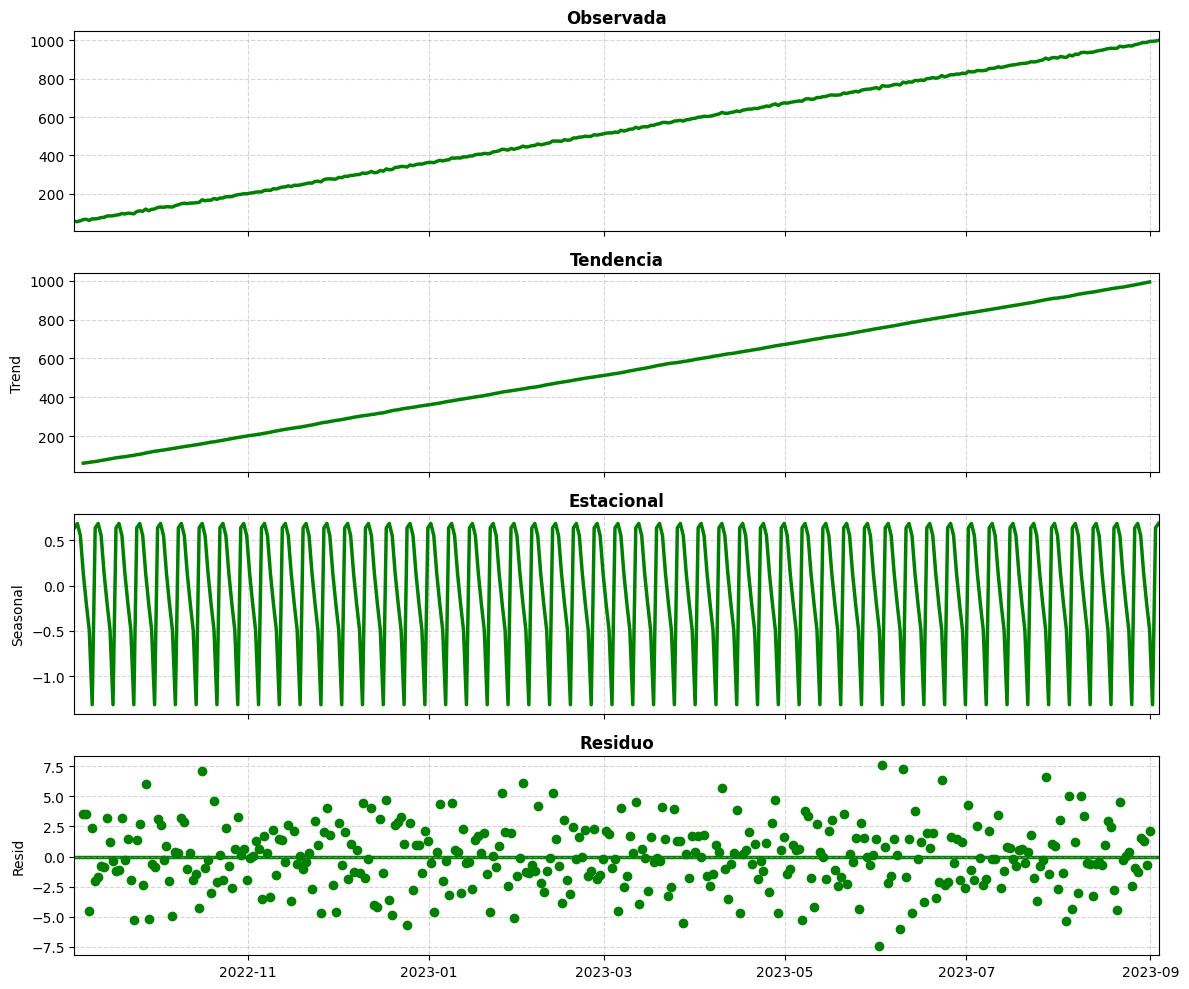

In [47]:
#Descomposición de la serie
decomp = seasonal_decompose(ts, model="additive")
fig = decomp.plot()
fig.set_size_inches(12, 10)

subplot_titles = ["Observada", "Tendencia", "Estacional", "Residuo"]

for ax, title in zip(fig.axes, subplot_titles):
    # Cambiar color de la línea a verde
    for line in ax.get_lines():
        line.set_color("green")
        line.set_linewidth(2.5)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [48]:
# Verificamos si la serie es estacionaria o no
result = adfuller(df["sales"])

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print("Critical Values:")

for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

if result[1] < 0.05:
    print("OK: La serie es estacionaria (rechazamos H0)")
else:
    print("KO: La serie no es estacionaria (no podemos rechazar H0)")

ADF Statistic: 0.5454
p-value: 0.9862
Critical Values:
   1%: -3.4491
   5%: -2.8698
   10%: -2.5712
KO: La serie no es estacionaria (no podemos rechazar H0)


In [49]:
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: 0.5454141937063888
p-value: 0.9861899815311067
Critical Values:
   1%: -3.4490648539347544
   5%: -2.8697861692116478
   10%: -2.5711631253228306


Se aplica el test ADF para evaluar la estacionariedad de la serie temporal,se  analiza el ADF estadístico, p-value y valores críticos, concluyendo la necesidad de diferenciación previa al modelado.

In [50]:
#Entrenamos datos utilizando el 80% de ellos
tam_train = int(len(df) * 0.8)
train = df[:tam_train]  
test = df[tam_train:] 

In [51]:
#Modelo arima
model_arima = auto_arima(train, seasonal=True, m=7, suppress_warnings=True, stepwise=True, error_action="ignore")


In [52]:
#Evaluación del modelo propuesto
forecast = model_arima.predict(n_periods=len(test))
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MSE: 7.45, RMSE: 2.73


In [53]:
#Alineación temporal de las predicciones
index_of_fc = test.index
forecast_df = pd.DataFrame(forecast, index=index_of_fc)

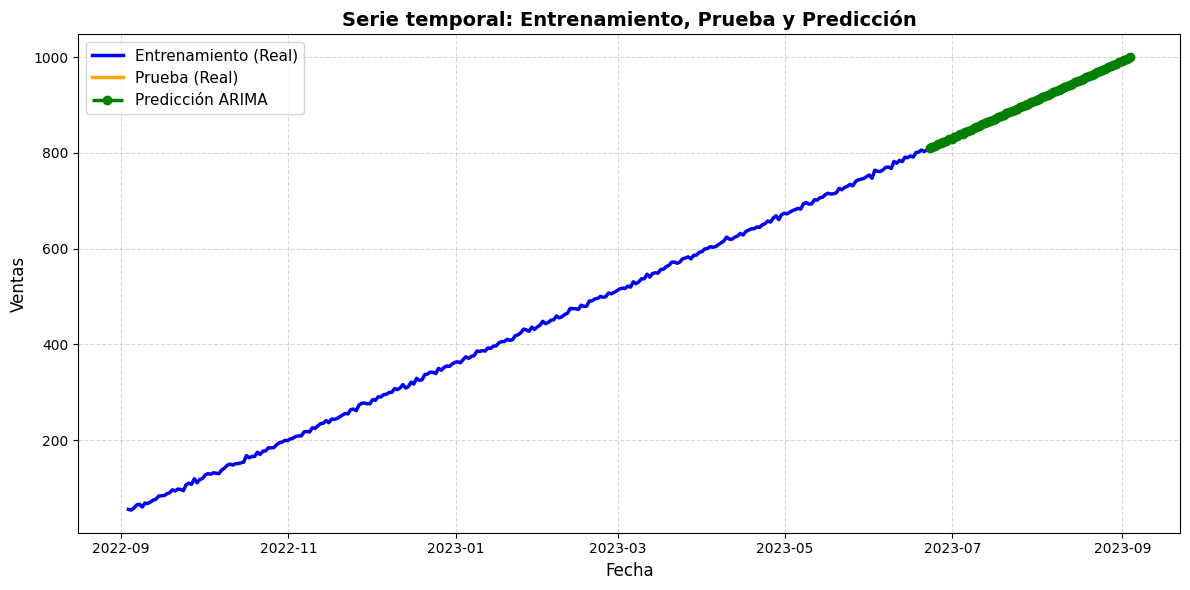

In [54]:
#Visualización: datos reales vs predicción ARIMA
plt.figure(figsize=(12,6))
#Serie de entrenamiento
plt.plot(train.index, train["sales"], label="Entrenamiento (Real)", color="blue", linewidth=2.5)
#Serie de prueba
plt.plot(test.index, test["sales"], label="Prueba (Real)", color="orange", linewidth=2.5)
#Predicción del modelo ARIMA
plt.plot(test.index, forecast, label="Predicción ARIMA", color="green", linestyle="--", linewidth=2.5, marker="o")

plt.title("Serie temporal: Entrenamiento, Prueba y Predicción", fontsize=14, fontweight="bold")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Ventas", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


In [55]:

# Métricas de evaluación del modelo ARIMA
test_series = test["sales"]
forecast_series = pd.Series(forecast, index=test_series.index)

mae = mean_absolute_error(test_series, forecast_series)
rmse = np.sqrt(mean_squared_error(test_series, forecast_series))
mask = test_series != 0
mape = np.mean(np.abs((test_series[mask] - forecast_series[mask]) / test_series[mask])) * 100

print(f"Métricas del modelo ARIMA:")
print(f"   MAE  : {mae:.2f} uds")
print(f"   RMSE : {rmse:.2f} uds")
print(f"   MAPE : {mape:.2f}%")


Métricas del modelo ARIMA:
   MAE  : 2.16 uds
   RMSE : 2.73 uds
   MAPE : 0.24%


In [57]:
#GuardaMOS el modelo
joblib.dump(model_arima, 'sales_model_ARIMA.pkl')
print("Modelo guardado: sales_model_ARIMA.pkl")

Modelo guardado: sales_model_ARIMA.pkl
